## Welcome to the pipeline of my zillow project

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

import aquire
import split_scale
import model

from jupyterthemes import jtplot
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = aquire.get_data("zillow")

In [3]:
train, test = split_scale.split_my_data(df, .80)

In [4]:
X_train = train.drop(columns="taxvaluedollarcnt")
X_test = test.drop(columns="taxvaluedollarcnt")
y_train = train[["taxvaluedollarcnt"]]
y_test = test[["taxvaluedollarcnt"]]

In [5]:
baseline = model.compute_baseline(y_train)

In [11]:
predictions = y_train.rename(columns = {"taxvaluedollarcnt":"actuals"})
predictions = model.linear_model(X_train, y_train, predictions).round(0)

In [12]:
model.evaluate(predictions.actuals, predictions.lm)

(338163467368.8412, 4049507521741873.0, 581518.2433671717, 0.38665860306904)

In [13]:
model.evaluate(predictions.actuals, baseline)

(551346230763.0707, 6602371113387771.0, 742526.9225846769, 0.0)

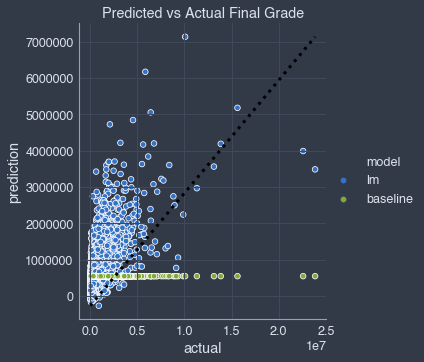

In [23]:
model.plot_linear_model(predictions.actuals,predictions.lm, baseline)
jtplot.style()

plt.plot([predictions.actuals.min(), predictions.actuals.max()], [predictions.lm.min(), predictions.lm.max()],
         c='black', ls=':', linewidth = 3)
plt.title('Predicted vs Actual Final Grade')
plt.show()